# Capstone 2: Modeling #

In this stage of the project we will create a series of machine learning models and evaluate their ability to accurately predict the prices of homes in Santiago, Chile. In order to obtain a baseline for performance, we will start by creating a dummy model which simply uses the mean price from the training data as the predicted price for all of the listings.  We will subsequently use Linear Regression, a Random Forest Regressor, and an XG Boost Regressor to make predictions, and compare those to our baseline. Each model will be evaluated using R-squared, Mean Absolute Error, and Root Mean Squared Error.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
import xgboost as xgb

In the previous stage we saved an original and scaled version of the training and testing data as csv files.  Now we import the files and create pandas DataFrames.

In [2]:
# Import train and test sets
X_train = pd.read_csv('train_data/X_train.csv')
X_train_scaled = pd.read_csv('train_data/X_train_scaled.csv')
y_train = pd.read_csv('train_data/y_train.csv')

X_test = pd.read_csv('test_data/X_test.csv')
X_test_scaled = pd.read_csv('test_data/X_test_scaled.csv')
y_test = pd.read_csv('test_data/y_test.csv')

In [3]:
# View unscaled training set
X_train.head()

,house,total_area,built_area,bedrooms,bathrooms,zone_east,zone_north,zone_northeast,zone_rural east,zone_rural west,zone_south,zone_southeast,zone_west
0,1,172.0,120.0,7,3,0,0,0,0,0,0,1,0
1,1,190.0,89.0,3,3,0,0,0,0,1,0,0,0
2,0,37.0,37.0,1,1,0,0,0,0,0,0,0,1
3,0,64.0,64.0,3,2,1,0,0,0,0,0,0,0
4,1,198.0,94.0,2,1,0,0,0,0,0,0,1,0


In [4]:
# View scaled training set
X_train_scaled.head()

,house,total_area,built_area,bedrooms,bathrooms,zone_east,zone_north,zone_northeast,zone_rural east,zone_rural west,zone_south,zone_southeast,zone_west
0,1.248715,0.600521,0.620878,2.178508,0.919623,-0.401790,-0.258872,-0.474516,-0.298069,-0.252588,-0.360579,2.725313,-0.297044
1,1.248715,0.688534,0.149475,0.224363,0.919623,-0.401790,-0.258872,-0.474516,-0.298069,3.959018,-0.360579,-0.366930,-0.297044
2,-0.800823,-1.608512,-1.742633,-1.799294,-1.315618,-0.401790,-0.258872,-0.474516,-0.298069,-0.252588,-0.360579,-0.366930,3.366502
3,-0.800823,-0.600592,-0.463586,0.224363,0.102062,2.488864,-0.258872,-0.474516,-0.298069,-0.252588,-0.360579,-0.366930,-0.297044
4,1.248715,0.723579,0.241302,-0.606953,-1.315618,-0.401790,-0.258872,-0.474516,-0.298069,-0.252588,-0.360579,2.725313,-0.297044


In [5]:
# View target variable
y_train.head()

,price_uf
0,4357.11
1,3500.00
2,2280.00
3,7300.00
4,2962.84


We begin by creating the dummy variable. First, we obtain the mean value of `y_train`, so that we can verify that it is the same as the constant given by the dummy regressor. The mean value is 7176.61 UF, which is roughly 270,000 USD. (This is incredibly high considering the average income in Chile, but that is a discussion for a different day.) 

In [6]:
# Find the mean price
train_mean = y_train.mean()
train_mean

price_uf    7176.613683
dtype: float64

In [7]:
# Fit the dummy regressor on the training data
dum_reg = DummyRegressor(strategy='mean')
start_time = time.time()
dum_reg.fit(X_train, y_train)
end_time = time.time()
dummy_time = round(end_time - start_time, 2)

dum_reg.constant_

array([[7176.6136834]])

We will record the run time of all of our models including this one, although in this case it is so small as to be negligible.

In [8]:
# print run time
print('run time: {} s'.format(dummy_time))

run time: 0.0 s


In [9]:
# Prediction is the mean price for every example
y_tr_pred = dum_reg.predict(X_train)
y_tr_pred[:5]

array([7176.6136834, 7176.6136834, 7176.6136834, 7176.6136834,
       7176.6136834])

In [10]:
# Mean price of training data also used as prediction for test set
start_time = time.time()
y_te_pred = dum_reg.predict(X_test)
end_time = time.time()
dummy_pred_time = round((end_time - start_time) * 1000, 2)
y_te_pred[:5]

array([7176.6136834, 7176.6136834, 7176.6136834, 7176.6136834,
       7176.6136834])

In [11]:
print('prediction time: {} ms'.format(dummy_pred_time))

prediction time: 0.33 ms


In [12]:
# R2 is 0 for training set, meaning the MSE is equal to the variance, slightly worse for test set
dummy_tr_r2 = round(r2_score(y_train, y_tr_pred), 4)
dummy_te_r2 = round(r2_score(y_test, y_te_pred), 4)

print('R2 for Training using Dummy Model:', dummy_tr_r2)
print('R2 for Testing using Dummy Model:', dummy_te_r2)

R2 for Training using Dummy Model: 0.0
R2 for Testing using Dummy Model: -0.0007


In [13]:
# Mean absolute error for train and test sets
dummy_tr_mae = round(mean_absolute_error(y_train, y_tr_pred), 2)
dummy_te_mae = round(mean_absolute_error(y_test, y_te_pred), 2)

print('MAE for Training using Dummy Model:', dummy_tr_mae)
print('MAE for Testing using Dummy Model:', dummy_te_mae)

MAE for Training using Dummy Model: 4957.43
MAE for Testing using Dummy Model: 4710.85


In [14]:
# Root mean squared error for train and test sets
dummy_tr_rmse = round(np.sqrt(mean_squared_error(y_train, y_tr_pred)), 2)
dummy_te_rmse = round(np.sqrt(mean_squared_error(y_test, y_te_pred)), 2)

print('RMSE for Training using Dummy Model:', dummy_tr_rmse)
print('RMSE for Testing using Dummy Model:', dummy_te_rmse)

RMSE for Training using Dummy Model: 7468.68
RMSE for Testing using Dummy Model: 6638.09


The results for R-squared are what we would expect. Namely, the training R-squared is 0 and the testing R-squared is just below 0. Notably, both of our error measures are higher for the training set, which is unusual. Below we see that the variance is higher in the training set, which is likely the reason for the higher error.

In [15]:
print('y_train variance:', float(y_train.var()))
print('y_test variance: ', float(y_test.var()))

y_train variance: 55795491.63953769
y_test variance:  44057852.695500135


## Linear Regression

This will be the first real model.  We will use a pipeline and grid search with cross validation to determine the optimal number of features, then see how the model performs according to different metrics.

In [16]:
# Create pipeline
pipe = make_pipeline(
    SelectKBest(f_regression),
    LinearRegression()
)

In [17]:
# Grid Search with pipeline
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1, verbose=1)

# Fit Model and recored run time
start_time = time.time()
linreg1 = lr_grid_cv.fit(X_train, y_train.values.flatten())
end_time = time.time()
linreg1_time = round(end_time - start_time, 2)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  58 out of  65 | elapsed:  1.6min remaining:   11.6s
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:  1.6min finished


In [18]:
# print run time
print('run time: {} sec'.format(linreg1_time))

run time: 97.57 sec


In [19]:
# Collect results of Grid Search
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [20]:
# The optimal number of best features is 13, which is all of them
linreg1.best_params_

{'selectkbest__k': 13}

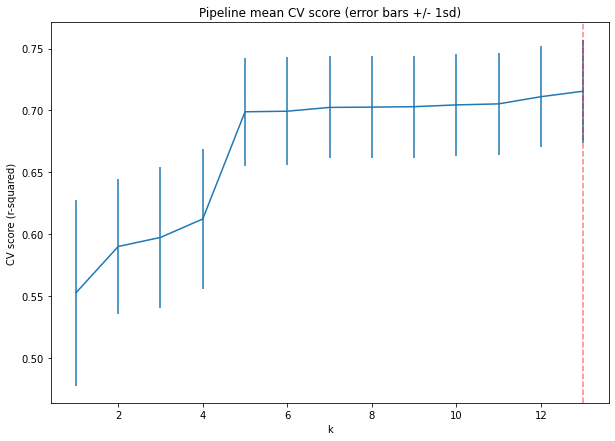

In [21]:
# See performance with different numbers of best features, improvement after top 5 features is small
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 7))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [22]:
# Call the `predict()` method of the model on both the train and test data
y_tr_pred1 = linreg1.predict(X_train)

start_time = time.time()
y_te_pred1 = linreg1.predict(X_test)
end_time = time.time()
linreg1_pred_time = round((end_time - start_time) * 1000, 2)

In [23]:
# Print prediction time
print('prediction time: {} ms'.format(linreg1_pred_time))

prediction time: 5.48 ms


In [24]:
# Obtain the R-squared for train and test set
linreg1_tr_r2 = round(r2_score(y_train, y_tr_pred1), 4)
linreg1_te_r2 = round(r2_score(y_test, y_te_pred1), 4)

print('R2 for Training using Linear Regression:', linreg1_tr_r2)
print('R2 for Testing using Linear Regression:', linreg1_te_r2)

R2 for Training using Linear Regression: 0.7215
R2 for Testing using Linear Regression: 0.7219


In [25]:
# Obtain the mean absolute error for train and test set
linreg1_tr_mae = round(mean_absolute_error(y_train, y_tr_pred1), 2)
linreg1_te_mae = round(mean_absolute_error(y_test, y_te_pred1), 2)

print('MAE for Training using Linear Regression:', linreg1_tr_mae)
print('MAE for Testing using Linear Regression:', linreg1_te_mae)

MAE for Training using Linear Regression: 2088.99
MAE for Testing using Linear Regression: 1991.0


In [26]:
print('Test MAE reduction compared to baseline: {}%'.format(round((1 - (linreg1_te_mae / dummy_te_mae)) * 100, 2)))

Test MAE reduction compared to baseline: 57.74%


In [27]:
# Obtain the root mean squared error for train and test set
linreg1_tr_rmse = round(np.sqrt(mean_squared_error(y_train, y_tr_pred1)), 2)
linreg1_te_rmse = round(np.sqrt(mean_squared_error(y_test, y_te_pred1)), 2)

print('RMSE for Training using Linear Regression:', linreg1_tr_rmse)
print('RMSE for Testing using Linear Regression:', linreg1_te_rmse)

RMSE for Training using Linear Regression: 3941.74
RMSE for Testing using Linear Regression: 3499.18


In [28]:
print('Test RMSE reduction compared to baseline: {}%'.format(round((1 - (linreg1_te_rmse / dummy_te_rmse)) * 100, 2)))

Test RMSE reduction compared to baseline: 47.29%


So using linear regression we can expect our predicted prices and the true prices to differ by an average of 1991 UF (about 76,500 USD at the time this notebook was created). This might seem like a lot, but simply using the mean price to make our predictions gives an average error of 4711 UF (roughly 181,000 USD). This means we have reduced the error by around 58%. Next we will repeat the process using scaled data.

In [29]:
# Fit linear regression model with Grid Search to scaled training data, record run time
lr_grid_cv2 = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1, verbose=1)

start_time = time.time()
linreg2 = lr_grid_cv2.fit(X_train_scaled, y_train.values.flatten())
end_time = time.time()
linreg2_time = round(end_time - start_time, 2)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:    0.6s finished


In [30]:
# print run time
print('run time: {} sec'.format(linreg2_time))

run time: 0.86 sec


In [31]:
# Collect results of Grid Search
score_mean = lr_grid_cv2.cv_results_['mean_test_score']
score_std = lr_grid_cv2.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv2.cv_results_['param_selectkbest__k']]

In [32]:
# Once again, the optimal number of best features is 13, which is all of them
linreg2.best_params_

{'selectkbest__k': 13}

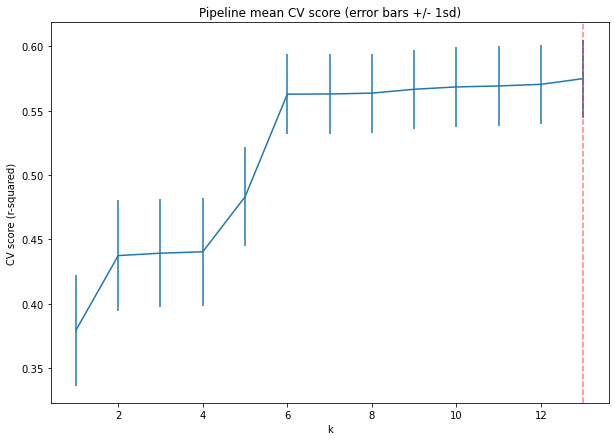

In [33]:
# See performance with different numbers of best features, improvement after top 6 features is small
best_k = lr_grid_cv2.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 7))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [34]:
# Call the `predict()` method of the model on both the (scaled) train and test data
y_tr_pred2 = linreg2.predict(X_train_scaled)

start_time = time.time()
y_te_pred2 = linreg2.predict(X_test_scaled)
end_time = time.time()
linreg2_pred_time = round((end_time - start_time) * 1000, 2)

In [35]:
# Print prediction time
print('prediction time: {} ms'.format(linreg2_pred_time))

prediction time: 4.91 ms


In [36]:
# Obtain the R-squared for (scaled) train and test set
linreg2_tr_r2 = round(r2_score(y_train, y_tr_pred2), 4)
linreg2_te_r2 = round(r2_score(y_test, y_te_pred2), 4)

print('R2 for Training using Linear Regression:', linreg2_tr_r2)
print('R2 for Linear Regression using Scaled Data:', linreg2_te_r2)

R2 for Training using Linear Regression: 0.5755
R2 for Linear Regression using Scaled Data: 0.5562


In [37]:
# Obtain the mean absolute error for (scaled) train and test set
linreg2_tr_mae = round(mean_absolute_error(y_train, y_tr_pred2), 2)
linreg2_te_mae = round(mean_absolute_error(y_test, y_te_pred2), 2)

print('MAE for Training using Linear Regression with Scaled Data:', linreg2_tr_mae)
print('MAE for Testing using Linear Regression with Scaled Data:', linreg2_te_mae)

MAE for Training using Linear Regression with Scaled Data: 2752.58
MAE for Testing using Linear Regression with Scaled Data: 2746.2


In [38]:
print('Test MAE reduction compared to baseline: {}%'.format(round((1 - (linreg2_te_mae / dummy_te_mae)) * 100, 2)))

Test MAE reduction compared to baseline: 41.7%


In [39]:
# Obtain the root mean squared error for (scaled) train and test set
linreg2_tr_rmse = round(np.sqrt(mean_squared_error(y_train, y_tr_pred2)), 2)
linreg2_te_rmse = round(np.sqrt(mean_squared_error(y_test, y_te_pred2)), 2)

print('RMSE for Training using Linear Regression with Scaled Data:', linreg2_tr_rmse)
print('RMSE for Testing using Linear Regression with Scaled Data:', linreg2_te_rmse)

RMSE for Training using Linear Regression with Scaled Data: 4865.91
RMSE for Testing using Linear Regression with Scaled Data: 4420.76


In [40]:
print('Test RMSE reduction compared to baseline: {}%'.format(round((1 - (linreg2_te_rmse / dummy_te_rmse)) * 100, 2)))

Test RMSE reduction compared to baseline: 33.4%


In this case, using scaled data with Linear Regression actually gives us worse results (lower R-squared, higher error) than using the original data, although the results are still much better than the dummy model.

## Random Forest Regressor

Next we will try a Random Forest Regressor, and we will tune the hyperparameters using a Randomized Search. We will fit the model to the training data using the best parameters, and then evaluate the performance according to various metrics.

In [41]:
# Define Hyperparameter Grid
random_grid = {'n_estimators': [20, 50, 100, 200, 400, 800],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [5, 10, 20, 30, 40, 50], # 60, 70, 80, 90, 100, None],
               'min_samples_split': [1, 2, 4, 8],
               'min_samples_leaf': [1, 2, 4, 8],
               'bootstrap': [True, False]}

# Create instance of Random Forest Regressor
rf = RandomForestRegressor()

# Create instance of Randomized Search
rf1 = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=1, 
                          random_state=42, n_jobs = -1)

# Fit model and record run time
start_time = time.time()
rf1.fit(X_train, y_train.values.flatten())
end_time = time.time()
rf1_time = round(end_time - start_time, 2)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.2min finished


In [42]:
# Check best parameters
rf1.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}

In [43]:
# print run time
print('runtime: {} sec'.format(rf1_time))

runtime: 194.44 sec


In [44]:
# Call the `predict()` method of the model on both the train and test data
y_tr_pred1 = rf1.predict(X_train)

start_time = time.time()
y_te_pred1 = rf1.predict(X_test)
end_time = time.time()
rf1_pred_time = round((end_time - start_time) * 1000, 2)

In [45]:
# Print prediction time
print('prediction time: {} ms'.format(rf1_pred_time))

prediction time: 254.18 ms


In [46]:
# Obtain the R-squared for train and test set
rf1_tr_r2 = round(r2_score(y_train, y_tr_pred1), 4)
rf1_te_r2 = round(r2_score(y_test, y_te_pred1), 4)

print('R2 for Training using Random Forest Regressor:', rf1_tr_r2)
print('R2 for Testing using Random Forest Regressor:', rf1_te_r2)

R2 for Training using Random Forest Regressor: 0.9061
R2 for Testing using Random Forest Regressor: 0.8419


In [47]:
# Obtain the mean absolute error for train and test set
rf1_tr_mae = round(mean_absolute_error(y_train, y_tr_pred1), 2)
rf1_te_mae = round(mean_absolute_error(y_test, y_te_pred1), 2)

print('MAE for Training using Random Forest Regressor:', rf1_tr_mae)
print('MAE for Testing using Random Forest Regressor:', rf1_te_mae)

MAE for Training using Random Forest Regressor: 1101.16
MAE for Testing using Random Forest Regressor: 1405.89


In [48]:
print('Test MAE reduction compared to baseline: {}%'.format(round((1 - (rf1_te_mae / dummy_te_mae)) * 100, 2)))

Test MAE reduction compared to baseline: 70.16%


In [49]:
# Obtain the root mean squared error for train and test set
rf1_tr_rmse = round(np.sqrt(mean_squared_error(y_train, y_tr_pred1)), 2)
rf1_te_rmse = round(np.sqrt(mean_squared_error(y_test, y_te_pred1)), 2)

print('RMSE for Training using Random Forest Regressor:', rf1_tr_rmse)
print('RMSE for Testing using Random Forest Regressor:', rf1_te_rmse)

RMSE for Training using Random Forest Regressor: 2288.97
RMSE for Testing using Random Forest Regressor: 2638.42


In [50]:
print('Test RMSE reduction compared to baseline: {}%'.format(round((1 - (rf1_te_rmse / dummy_te_rmse)) * 100, 2)))

Test RMSE reduction compared to baseline: 60.25%


The Random Forest Regressor has performed even better than Linear Regression, reducing the MAE from the baseline model by over 70%. However, we can still expect the predictions to be off by about 1389 UF, or roughly 53,000 USD, which is substantial. The plot below shows which features were considered by the model to be most important, with `built_area` coming in first. In general, this model does not place high importance on the zones. 

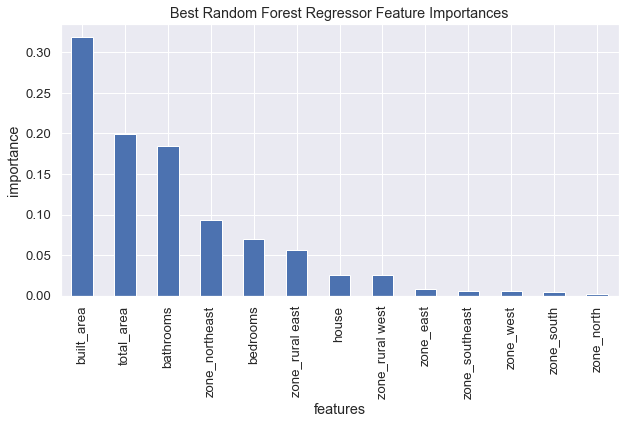

In [51]:
# Plot feature importance for random forest model
sns.set(font_scale=1.2)
plt.subplots(figsize=(10, 5))
imps = rf1.best_estimator_.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best Random Forest Regressor Feature Importances');

Next we will repeat the process using the scaled data.

In [52]:
# Create new instance of Random Forest Regressor, we will use the same paramter grid as before
rf = RandomForestRegressor()

# Create instance of Randomized Search
rf2 = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 200, cv = 5, verbose=1, 
                          random_state=42, n_jobs = -1)

# Fit Model and recored run time
start_time = time.time()
rf2.fit(X_train_scaled, y_train.values.flatten())
end_time = time.time()
rf2_time = round(end_time - start_time, 2)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  6.1min finished


In [53]:
# Check best parameters
rf2.best_params_

{'n_estimators': 100,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}

In [54]:
# print run time
print('runtime: {} sec'.format(rf2_time))

runtime: 368.55 sec


In [55]:
# Call the `predict()` method of the model on both the (scaled) train and test data
y_tr_pred2 = rf2.predict(X_train_scaled)

start_time = time.time()
y_te_pred2 = rf2.predict(X_test_scaled)
end_time = time.time()
rf2_pred_time = round((end_time - start_time) * 1000, 2)

In [56]:
# Print prediction time
print('prediction time: {} ms'.format(rf2_pred_time))

prediction time: 42.86 ms


In [57]:
# Obtain the R-squared for (scaled) train and test set
rf2_tr_r2 = round(r2_score(y_train, y_tr_pred2), 4)
rf2_te_r2 = round(r2_score(y_test, y_te_pred2), 4)

print('R2 for Training using Random Forest Regressor with Scaled Data:', rf2_tr_r2)
print('R2 for Testing using Random Forest Regressor with Scaled Data:', rf2_te_r2)

R2 for Training using Random Forest Regressor with Scaled Data: 0.9392
R2 for Testing using Random Forest Regressor with Scaled Data: 0.8467


In [58]:
# Obtain the mean absolute error for (scaled) train and test set
rf2_tr_mae = round(mean_absolute_error(y_train, y_tr_pred2), 2)
rf2_te_mae = round(mean_absolute_error(y_test, y_te_pred2), 2)

print('MAE for Training using Random Forest Regressor with Scaled Data:', rf2_tr_mae)
print('MAE for Testing using Random Forest Regressor with Scaled Data:', rf2_te_mae)

MAE for Training using Random Forest Regressor with Scaled Data: 908.64
MAE for Testing using Random Forest Regressor with Scaled Data: 1407.96


In [59]:
print('Test MAE reduction compared to baseline: {}%'.format(round((1 - (rf2_te_mae / dummy_te_mae)) * 100, 2)))

Test MAE reduction compared to baseline: 70.11%


In [60]:
# Obtain the root mean squared error for (scaled) train and test set
rf2_tr_rmse = round(np.sqrt(mean_squared_error(y_train, y_tr_pred2)), 2)
rf2_te_rmse = round(np.sqrt(mean_squared_error(y_test, y_te_pred2)), 2)

print('RMSE for Training using Random Forest Regressor with Scaled Data:', rf2_tr_rmse)
print('RMSE for Testing using Random Forest Regressor with Scaled Data:', rf2_te_rmse)

RMSE for Training using Random Forest Regressor with Scaled Data: 1842.31
RMSE for Testing using Random Forest Regressor with Scaled Data: 2597.76


In [61]:
print('Test RMSE reduction compared to baseline: {}%'.format(round((1 - (rf2_te_rmse / dummy_te_rmse)) * 100, 2)))

Test RMSE reduction compared to baseline: 60.87%


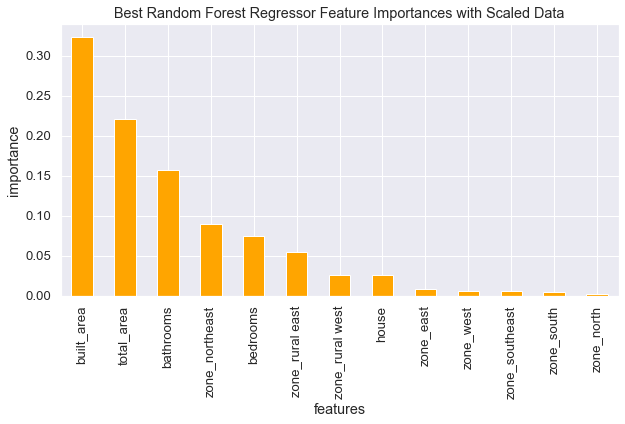

In [62]:
# Plot feature importance for random forest model using scaled data
plt.subplots(figsize=(10, 5))
imps = rf2.best_estimator_.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar', color='orange')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best Random Forest Regressor Feature Importances with Scaled Data');

With the Random Forest Regressor, the results from scaled data are almost identical to the original data.  The distribution of feature importance is also quite similar.

## XG Boost Regressor ##

The final model we try will be an XG Boost Regressor. Again we will use a Randomized Search to tune the hyperparameters.

In [63]:
# Define Hyperparameter Grid
gbm_param_grid = {'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.5],
                  'gamma': [0, 0.1, 0.5, 1.0, 5, 10],
                  'max_depth': [5, 10, 15, 20],
                  'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
                  'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                  'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                  'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
                  'n_estimators': [100, 200, 400, 600, 800, 1000],
                  'subsample': np.arange(0.05, 1.05, 0.05)}

# Create instance of XG Boost Regressor
gbm = xgb.XGBRegressor()

# Create instance of Randomized Search
gbm1 = RandomizedSearchCV(estimator=gbm, param_distributions=gbm_param_grid, n_iter=100, 
                           scoring='neg_mean_squared_error', cv=5, random_state=42, n_jobs = -1, verbose=1)

# Fit model and record run time
start_time = time.time()
gbm1.fit(X_train, y_train)
end_time = time.time()
gbm1_time = round(end_time - start_time, 2)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.4min finished


In [64]:
# Check best parameters
gbm1.best_params_

{'subsample': 0.55,
 'reg_lambda': 1.0,
 'n_estimators': 1000,
 'min_child_weight': 3.0,
 'max_depth': 15,
 'learning_rate': 0.01,
 'gamma': 1.0,
 'colsample_bytree': 0.9,
 'colsample_bylevel': 0.4}

In [65]:
# print run time
print('runtime: {} sec'.format(gbm1_time))

runtime: 444.84 sec


In [66]:
# Call the `predict()` method of the model on both the train and test data
y_tr_pred1 = gbm1.predict(X_train)

start_time = time.time()
y_te_pred1 = gbm1.predict(X_test)
end_time = time.time()
gbm1_pred_time = round((end_time - start_time) * 1000, 2)

In [67]:
# Print prediction time
print('prediction time: {} ms'.format(gbm1_pred_time))

prediction time: 129.88 ms


In [68]:
# Obtain the R-squared for train and test set
xgb1_tr_r2 = round(r2_score(y_train, y_tr_pred1), 4)
xgb1_te_r2 = round(r2_score(y_test, y_te_pred1), 4)

print('R2 for Training using XG Boost Regressor:', xgb1_tr_r2)
print('R2 for Testing using XG Boost Regressor:', xgb1_te_r2)

R2 for Training using XG Boost Regressor: 0.9556
R2 for Testing using XG Boost Regressor: 0.8441


In [69]:
# Obtain the mean absolute error for train and test set
xgb1_tr_mae = round(mean_absolute_error(y_train, y_tr_pred1), 2)
xgb1_te_mae = round(mean_absolute_error(y_test, y_te_pred1), 2)

print('MAE for Training using XG Boost Regressor:', xgb1_tr_mae)
print('MAE for Testing using XG Boost Regressor:', xgb1_te_mae)

MAE for Training using XG Boost Regressor: 858.66
MAE for Testing using XG Boost Regressor: 1412.89


In [70]:
print('Test MAE reduction compared to baseline: {}%'.format(round((1 - (xgb1_te_mae / dummy_te_mae)) * 100, 2)))

Test MAE reduction compared to baseline: 70.01%


In [71]:
# Obtain the root mean squared error for train and test set
xgb1_tr_rmse = round(np.sqrt(mean_squared_error(y_train, y_tr_pred1)), 2)
xgb1_te_rmse = round(np.sqrt(mean_squared_error(y_test, y_te_pred1)), 2)

print('RMSE for Training using XG Boost Regressor:', xgb1_tr_rmse)
print('RMSE for Testing using XG Boost Regressor:', xgb1_te_rmse)

RMSE for Training using XG Boost Regressor: 1573.18
RMSE for Testing using XG Boost Regressor: 2620.16


In [72]:
print('Test RMSE reduction compared to baseline: {}%'.format(round((1 - (xgb1_te_rmse / dummy_te_rmse)) * 100, 2)))

Test RMSE reduction compared to baseline: 60.53%


Interestingly, the results from the XG Boost Regressor are almost exactly the same as both Random Forest models, although the features the model considers to be most important are completely different (shown below). This could be because boosting algorithms focus on examples with high error. The most important feature in this case is being located in the northeast zone of the city. It makes sense that listings in this zone would cause problems, because they are likely to be much more expensive than similar homes in other areas.

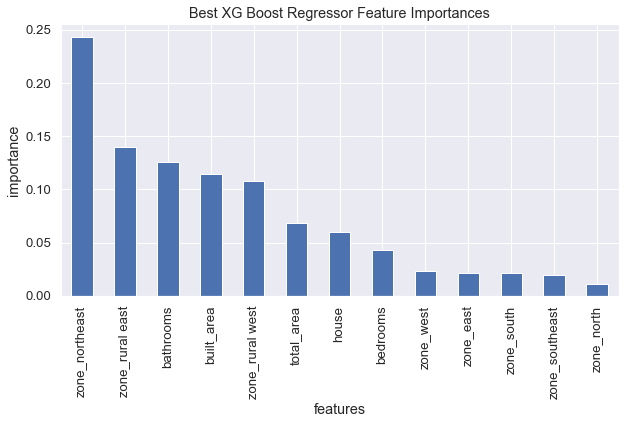

In [73]:
# Plot feature importance for XG Boost model
plt.subplots(figsize=(10, 5))
imps = gbm1.best_estimator_.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best XG Boost Regressor Feature Importances');

Finally, we will use an XG Boost Regressor with the scaled data to see if there is an improvement, although up to this point, the scaling has not benefitted the results

In [74]:
# Create new instance of XG Boost Regressor, we will use the same paramter grid as before
gbm = xgb.XGBRegressor()

# Create instance of Randomized Search
gbm2 = RandomizedSearchCV(estimator=gbm, param_distributions=gbm_param_grid, n_iter=100, 
                           scoring='neg_mean_squared_error', cv=5, random_state=42, n_jobs = -1, verbose=1)

# Fit model and record run time
start_time = time.time()
gbm2.fit(X_train_scaled, y_train)
end_time = time.time()
gbm2_time = round(end_time - start_time, 2)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.9min finished


In [75]:
# Check best parameters
gbm2.best_params_

{'subsample': 0.9000000000000001,
 'reg_lambda': 1.0,
 'n_estimators': 1000,
 'min_child_weight': 5.0,
 'max_depth': 20,
 'learning_rate': 0.005,
 'gamma': 1.0,
 'colsample_bytree': 1.0,
 'colsample_bylevel': 0.4}

In [76]:
# print run time
print('runtime: {} sec'.format(gbm2_time))

runtime: 419.94 sec


In [77]:
# Call the `predict()` method of the model on both the (scaled) train and test data
y_tr_pred2 = gbm2.predict(X_train_scaled)

start_time = time.time()
y_te_pred2 = gbm2.predict(X_test_scaled)
end_time = time.time()
gbm2_pred_time = round((end_time - start_time) * 1000, 2)

In [78]:
# Print prediction time
print('prediction time: {} ms'.format(gbm2_pred_time))

prediction time: 206.13 ms


In [79]:
# Obtain the R-squared for (scaled) train and test set
xgb2_tr_r2 = round(r2_score(y_train, y_tr_pred2), 4)
xgb2_te_r2 = round(r2_score(y_test, y_te_pred2), 4)

print('R2 for Training using XG Boost Regressor with Scaled Data:', xgb2_tr_r2)
print('R2 for Testing using XG Boost Regressor with Scaled Data:', xgb2_te_r2)

R2 for Training using XG Boost Regressor with Scaled Data: 0.9411
R2 for Testing using XG Boost Regressor with Scaled Data: 0.8489


In [80]:
# Obtain the mean absolute error for (scaled) train and test set
xgb2_tr_mae = round(mean_absolute_error(y_train, y_tr_pred2), 2)
xgb2_te_mae = round(mean_absolute_error(y_test, y_te_pred2), 2)

print('MAE for Training using XG Boost Regressor with Scaled Data:', xgb2_tr_mae)
print('MAE for Testing using XG Boost Regressor with Scaled Data:', xgb2_te_mae)

MAE for Training using XG Boost Regressor with Scaled Data: 914.83
MAE for Testing using XG Boost Regressor with Scaled Data: 1371.83


In [81]:
print('Test MAE reduction compared to baseline: {}%'.format(round((1 - (xgb2_te_mae / dummy_te_mae)) * 100, 2)))

Test MAE reduction compared to baseline: 70.88%


In [82]:
# Obtain the root mean squared error for (scaled) train and test set
xgb2_tr_rmse = round(np.sqrt(mean_squared_error(y_train, y_tr_pred2)), 2)
xgb2_te_rmse = round(np.sqrt(mean_squared_error(y_test, y_te_pred2)), 2)

print('RMSE for Training using XG Boost Regressor with Scaled Data:', xgb2_tr_rmse)
print('RMSE for Testing using XG Boost Regressor with Scaled Data:', xgb2_te_rmse)

RMSE for Training using XG Boost Regressor with Scaled Data: 1812.94
RMSE for Testing using XG Boost Regressor with Scaled Data: 2579.13


In [83]:
print('Test RMSE reduction compared to baseline: {}%'.format(round((1 - (xgb2_te_rmse / dummy_te_rmse)) * 100, 2)))

Test RMSE reduction compared to baseline: 61.15%


As with the Random Forest model, using the scaled data has produced essentially te same results as the original data, and also the same feature importance.

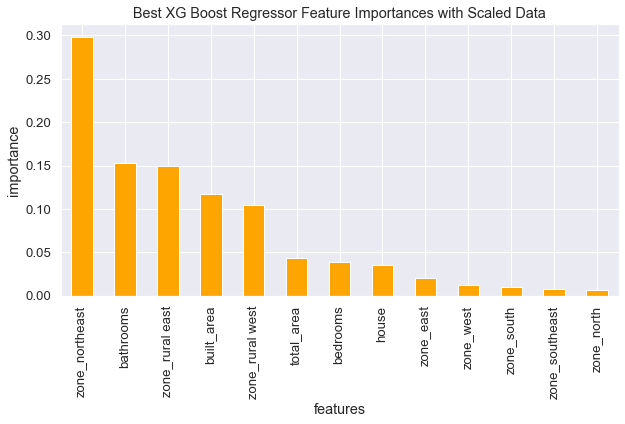

In [84]:
# Plot feature importance for XG Boost model using scaled data
plt.subplots(figsize=(10, 5))
imps = gbm2.best_estimator_.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar', color='orange')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best XG Boost Regressor Feature Importances with Scaled Data');

## Average of Models ##

In recent years some of the models that have been most successful have actually been combinations of multiple models. After experimenting with multiple combinations of the models, the best seems to be a 50 / 50 split between the Random Forest Regressor and the XG Boost Regressor. Unfortunately, the Linear Regression model only lowered the overall score, although there are examples that it is better at predicting, as we shall see. Since using scaled data has not offered any benefit so far, we will use the only the original data in the next section.

In [85]:
def avg_models(X_tr, X_te, y_tr, y_te):
    
    y_tr_preds_rf = rf1.predict(X_tr)
    y_te_preds_rf = rf1.predict(X_te)

    y_tr_preds_xgb = gbm1.predict(X_tr)
    y_te_preds_xgb = gbm1.predict(X_te)
    
    y_tr_preds_avg = ((y_tr_preds_rf.flatten() * 0.5) + (y_tr_preds_xgb.flatten() * 0.5))
    y_te_preds_avg = ((y_te_preds_rf.flatten() * 0.5) + (y_te_preds_xgb.flatten() * 0.5))
    
    return y_tr_preds_avg, y_te_preds_avg

In [86]:
y_tr_preds_avg, y_te_preds_avg = avg_models(X_train, X_test, y_train, y_test)

In [87]:
# Obtain the R-squared for train and test set
avg_tr_r2 = round(r2_score(y_train, y_tr_preds_avg), 4)
avg_te_r2 = round(r2_score(y_test, y_te_preds_avg), 4)

print('R2 for Training using Average of Models:', avg_tr_r2)
print('R2 for Testing using Average of Models:', avg_te_r2)

R2 for Training using Average of Models: 0.9364
R2 for Testing using Average of Models: 0.8477


In [88]:
# Obtain the mean absolute error for train and test set
avg_tr_mae = round(mean_absolute_error(y_train, y_tr_preds_avg), 2)
avg_te_mae = round(mean_absolute_error(y_test, y_te_preds_avg), 2)

print('MAE for Training using Average of Models:', avg_tr_mae)
print('MAE for Testing using Average of Models:', avg_te_mae)

MAE for Training using Average of Models: 964.22
MAE for Testing using Average of Models: 1389.39


In [89]:
print('MAE reduction compared to baseline: {}%'.format(round((1 - (avg_te_mae / dummy_te_mae)) * 100, 2)))

MAE reduction compared to baseline: 70.51%


In [90]:
# Obtain the root mean squared error for train and test set
avg_tr_rmse = round(np.sqrt(mean_squared_error(y_train, y_tr_preds_avg)), 2)
avg_te_rmse = round(np.sqrt(mean_squared_error(y_test, y_te_preds_avg)), 2)

print('RMSE for Training using XG Boost Regressor:', avg_tr_rmse)
print('RMSE for Testing using XG Boost Regressor:', avg_te_rmse)

RMSE for Training using XG Boost Regressor: 1883.89
RMSE for Testing using XG Boost Regressor: 2589.42


In [91]:
print('RMSE reduction compared to baseline: {}%'.format(round((1 - (avg_te_rmse / dummy_te_rmse)) * 100, 2)))

RMSE reduction compared to baseline: 60.99%


The scores obtained from the ensemble model are slightly better than those obtained by either model individually, although only slightly.

## Model Comparison ##

Now it is time to view all of the models side by side to compare their performance. We can start by creating a pandas DataFrame to compare the results on the testing data. In the DataFrame below, each row is a model, and each column is a performance metric. Note that we have includedthe dummy model, as well as the combination of Random Forest and XG Boost. The run time for the combination is simply the sum of the run time for each of the two algorithms used.

In [93]:
# Create a dataframe for model comparison
model_comparison = pd.DataFrame({'model': ['Dummy', 'LinearRegression', 'LinReg_Scaled', 'RandomForest', 'RF_Scaled', 'XGB', 'XGB_Scaled', 'Average'], 
                                 'r2':  [dummy_te_r2, linreg1_te_r2, linreg2_te_r2, rf1_te_r2, rf2_te_r2, xgb1_te_r2, xgb2_te_r2, avg_te_r2],
                                 'MAE': [dummy_te_mae, linreg1_te_mae, linreg2_te_mae, rf1_te_mae, rf2_te_mae, xgb1_te_mae, xgb2_te_mae, avg_te_mae],
                                 'RMSE': [dummy_te_rmse, linreg1_te_rmse, linreg2_te_rmse, rf1_te_rmse, rf2_te_rmse, xgb1_te_rmse, xgb2_te_rmse, avg_te_rmse],
                                 'run_time': [dummy_time, linreg1_time, linreg2_time, rf1_time, rf2_time, gbm1_time, gbm2_time, (rf1_time + gbm1_time)],
                                 'pred_time_ms': [dummy_pred_time, linreg1_pred_time, linreg2_pred_time, rf1_pred_time, rf2_pred_time, gbm1_pred_time, 
                                                  gbm2_pred_time, (rf1_pred_time + gbm1_pred_time)]
                                })

model_comparison = model_comparison.set_index('model')
model_comparison

,r2,MAE,RMSE,run_time,pred_time_ms
model,,,,,
Dummy,-0.0007,4710.85,6638.09,0.00,0.33
LinearRegression,0.7219,1991.00,3499.18,97.57,5.48
LinReg_Scaled,0.5562,2746.20,4420.76,0.86,4.91
RandomForest,0.8419,1405.89,2638.42,194.44,254.18
RF_Scaled,0.8467,1407.96,2597.76,368.55,42.86
XGB,0.8441,1412.89,2620.16,444.84,129.88
XGB_Scaled,0.8489,1371.83,2579.13,419.94,206.13
Average,0.8477,1389.39,2589.42,639.28,384.06


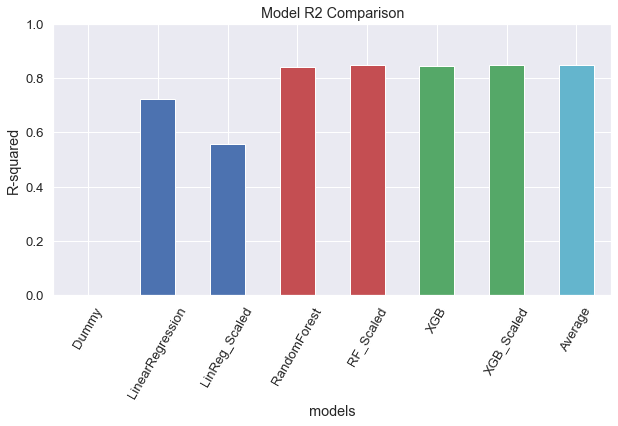

In [94]:
# Plot R-squared for each model
plt.subplots(figsize=(10, 5))
model_comparison['r2'].plot(kind='bar', color=['y', 'b', 'b', 'r', 'r', 'g', 'g', 'c'])
plt.ylim(0, 1)
plt.xlabel('models')
plt.ylabel('R-squared')
plt.title('Model R2 Comparison')
plt.xticks(rotation=60);

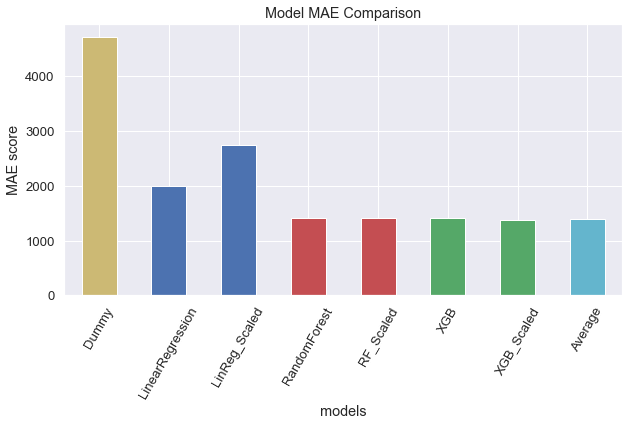

In [95]:
# Plot Mean Absolute Error for each model
plt.subplots(figsize=(10, 5))
model_comparison['MAE'].plot(kind='bar', color=['y', 'b', 'b', 'r', 'r', 'g', 'g', 'c'])
plt.xlabel('models')
plt.ylabel('MAE score')
plt.title('Model MAE Comparison')
plt.xticks(rotation=60);

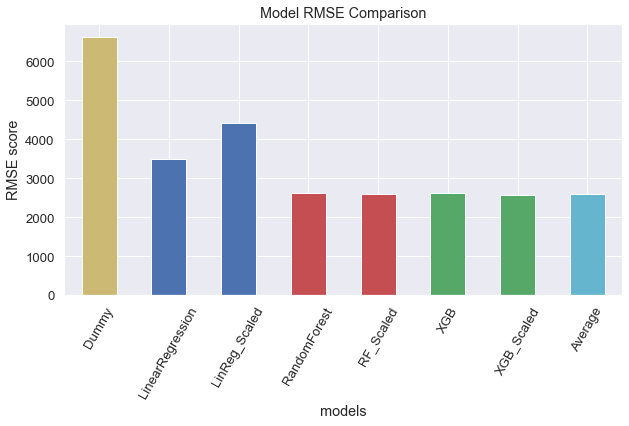

In [96]:
# Plot Root Mean Squared Error for each model
plt.subplots(figsize=(10, 5))
model_comparison['RMSE'].plot(kind='bar', color=['y', 'b', 'b', 'r', 'r', 'g', 'g', 'c'])
plt.xlabel('models')
plt.ylabel('RMSE score')
plt.title('Model RMSE Comparison')
plt.xticks(rotation=60);

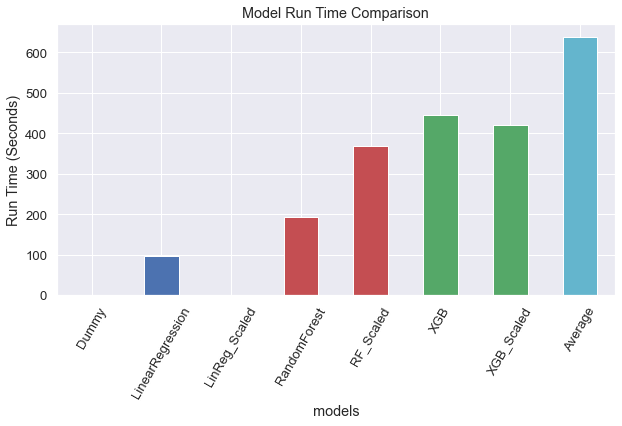

In [97]:
# Plot Run Time for each model
plt.subplots(figsize=(10, 5))
model_comparison['run_time'].plot(kind='bar', color=['y', 'b', 'b', 'r', 'r', 'g', 'g', 'c'])
plt.xlabel('models')
plt.ylabel('Run Time (Seconds)')
plt.title('Model Run Time Comparison')
plt.xticks(rotation=60);

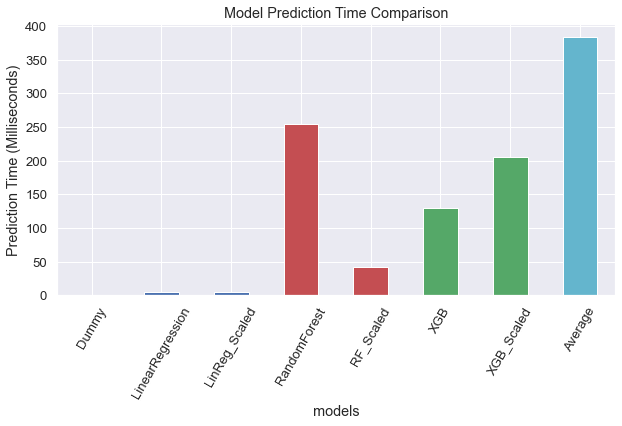

In [98]:
# Plot Prediction Time for each model
plt.subplots(figsize=(10, 5))
model_comparison['pred_time_ms'].plot(kind='bar', color=['y', 'b', 'b', 'r', 'r', 'g', 'g', 'c'])
plt.xlabel('models')
plt.ylabel('Prediction Time (Milliseconds)')
plt.title('Model Prediction Time Comparison')
plt.xticks(rotation=60);

Although the combination of models gives the best performance, we see that there is a negligible difference between the Random Forest models, the XG Boost Models, and the combination. All of them have an MAE that hovers a little over 50,000 USD. With the average price being roughly 270,000 USD, this means this means an error of roughly 18.5%.

Of these models, the Random Forest has the lowest run time. Strangely, the Random Forest had a high prediction time, although this was probably the result of some anomaly. Now we will take some random examples from the data and see how the predictions made by our different algorithms compare to the real prices.

In [99]:
sample_df = X_test.sample(n=10, random_state=23)
sample_df

,house,total_area,built_area,bedrooms,bathrooms,zone_east,zone_north,zone_northeast,zone_rural east,zone_rural west,zone_south,zone_southeast,zone_west
1527,1,5000.0,300.0,5,5,0,0,0,0,1,0,0,0
1324,0,64.0,64.0,1,1,0,1,0,0,0,0,0,0
315,1,492.0,212.0,4,3,0,0,0,1,0,0,0,0
1136,0,57.0,57.0,3,2,0,0,0,0,0,1,0,0
1580,0,47.0,47.0,3,1,0,0,0,0,0,0,0,1
1515,0,64.0,64.0,2,2,1,0,0,0,0,0,0,0
767,1,225.0,137.0,4,3,1,0,0,0,0,0,0,0
1123,1,134.0,125.0,3,3,0,0,0,0,1,0,0,0
821,0,86.0,86.0,2,2,0,0,1,0,0,0,0,0
1219,0,36.0,36.0,2,1,0,0,0,0,0,0,0,0


In [100]:
# Create prediction intervals 
true_preds = y_test.iloc[list(sample_df.index)].values.flatten()

mean_price = float(train_mean)

lr_preds = linreg1.predict(sample_df).flatten()
lr_margin = linreg1_te_mae / mean_price
lr_min = lr_preds - (lr_preds * lr_margin)
lr_max = lr_preds + (lr_preds * lr_margin)

rf_preds = rf1.predict(sample_df)
rf_margin = rf1_te_mae / mean_price
rf_min = rf_preds - (rf_preds * rf_margin)
rf_max = rf_preds + (rf_preds * rf_margin)

xgb_preds = np.float64(gbm1.predict(sample_df))
xgb_margin = xgb1_te_mae / mean_price
xgb_min = xgb_preds - (xgb_preds * xgb_margin)
xgb_max = xgb_preds + (xgb_preds * xgb_margin)


avg_preds = (rf_preds + xgb_preds) / 2
avg_mae = (rf1_te_mae + xgb1_te_mae) / 2
avg_margin = avg_te_mae / mean_price
avg_min = avg_preds - (avg_preds * avg_margin)
avg_max = avg_preds + (avg_preds * avg_margin)

In [101]:
# Compare prediction intervals to real prices

preds_int_df = pd.DataFrame({'true_pred': true_preds, 
                             'lr_min': lr_min, 'lr_max': lr_max, 'in_lr_margin': (lr_min < true_preds) & (true_preds < lr_max),
                             'rf_min': rf_min, 'rf_max': rf_max, 'in_rf_margin': (rf_min < true_preds) & (true_preds < rf_max),
                             'xgb_min': xgb_min, 'xgb_max': xgb_max, 'in_xgb_margin': (xgb_min < true_preds) & (true_preds < xgb_max),
                             'avg_min': avg_min, 'avg_max': avg_max, 'in_avg_margin': (avg_min < true_preds) & (true_preds < avg_max),
                            })

preds_int_df.index = sample_df.index
preds_int_df = preds_int_df.round(2)
preds_int_df

,true_pred,lr_min,lr_max,in_lr_margin,rf_min,rf_max,in_rf_margin,xgb_min,xgb_max,in_xgb_margin,avg_min,avg_max,in_avg_margin
1527,9000.00,9298.17,16438.17,False,9308.55,13844.13,False,8870.97,13220.13,True,9121.15,13500.74,False
1324,1394.28,1709.93,3022.98,False,1856.21,2760.65,False,1780.90,2654.03,False,1824.84,2701.05,False
315,13900.00,11511.95,20351.90,True,13066.63,19433.33,True,13227.08,19711.92,True,13192.50,19526.98,True
1136,3067.41,1994.43,3525.94,True,2426.88,3609.37,True,2389.20,3560.56,True,2416.38,3576.62,True
1580,1847.42,550.30,972.87,False,1810.64,2692.88,True,1744.25,2599.41,True,1783.59,2640.00,True
1515,4800.00,3875.98,6852.32,True,3870.93,5757.03,True,3885.51,5790.46,True,3891.67,5760.29,True
767,5350.53,6557.40,11592.79,False,7307.23,10867.67,False,7243.75,10795.14,False,7300.70,10806.19,False
1123,4000.00,3294.22,5823.83,True,3580.66,5325.33,True,3337.10,4973.19,True,3470.80,5137.34,True
821,8100.00,7510.75,13278.21,True,5733.73,8527.48,True,5925.68,8830.86,True,5849.98,8658.89,True
1219,1790.00,1266.58,2239.18,True,1668.28,2481.15,True,1735.14,2585.83,True,1707.64,2527.57,True


Above we have a few example listings taken from the test set, and below is a DataFrame showing the real prices compared to ranges given by each model. One interesting point is that the models are often pretty consistent with each other, even if they all differ significantly from the true price.  We see this in the first two examples. Other times, the two tree-based algorithms give similar ranges, while Linear Regression gives a different range, such as rows `1580`, `821`, or `1219`. Also, we can find at least one example where each model outperforms the others.

In [102]:
# Save the best models to a pickle file

from sklearn import __version__ as sklearn_version
import datetime
import pickle as pkl

rf_model = rf1.best_estimator_
rf_model.version = '1.0'
rf_model.pandas_version = pd.__version__
rf_model.numpy_version = np.__version__
rf_model.sklearn_version = sklearn_version
rf_model.X_columns = [col for col in X_train.columns]
rf_model.build_datetime = datetime.datetime.now()

xgb_model = gbm1.best_estimator_
xgb_model.version = '1.0'
xgb_model.pandas_version = pd.__version__
xgb_model.numpy_version = np.__version__
xgb_model.sklearn_version = sklearn_version
xgb_model.X_columns = [col for col in X_train.columns]
xgb_model.build_datetime = datetime.datetime.now()

with open('housing_price_models.pkl', 'wb') as file:
    pkl.dump([rf_model, xgb_model], file)